In [1]:
import requests
import time
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Importing of the training data

In [2]:
df  = pd.read_csv('./data/train.csv')
df.drop_duplicates(subset='text',keep='last',inplace=True)
print(df.shape)

(7503, 5)


In [3]:
#checking the distribution of labels
print(df.target.value_counts())
print(df.target.value_counts(normalize=True))

0    4307
1    3196
Name: target, dtype: int64
0    0.574037
1    0.425963
Name: target, dtype: float64


# WORDCLOUD

In [4]:
#to prevent the following from appearing in wordcloud
stop_words = text.ENGLISH_STOP_WORDS.union(['www','https','http','amp'])

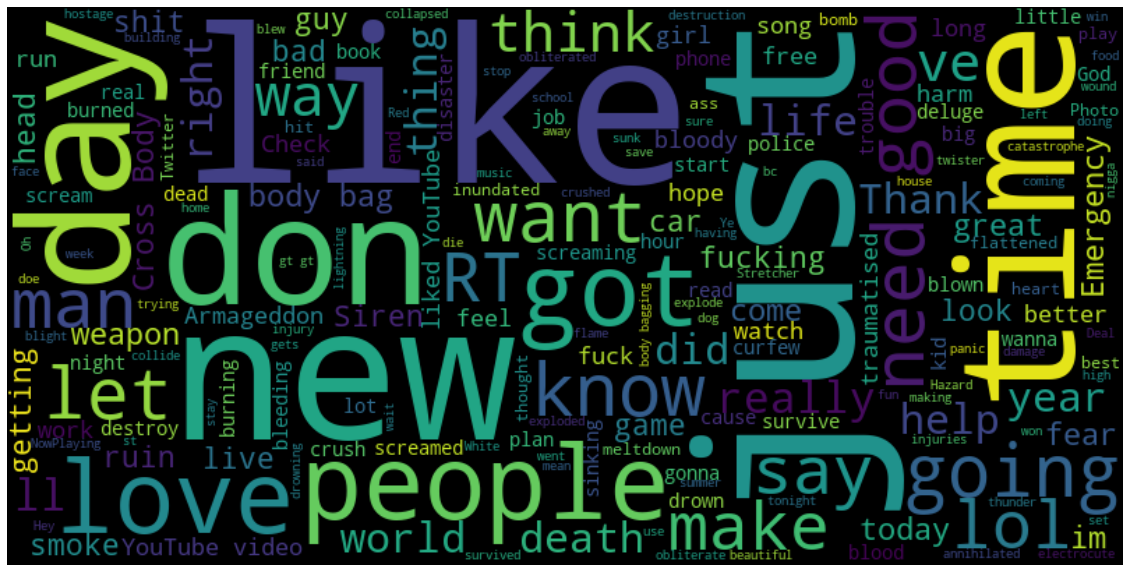

In [5]:
#frequently occuring word of non-disaster related tweets
text = " ".join(tweet for tweet in df[df['target']==0]['text'])
stopwords = set(stop_words)
wordcloud = WordCloud(stopwords=stopwords, background_color="black",regexp=r"[a-zA-Z]{2,}",width=800, height=400).generate(text)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

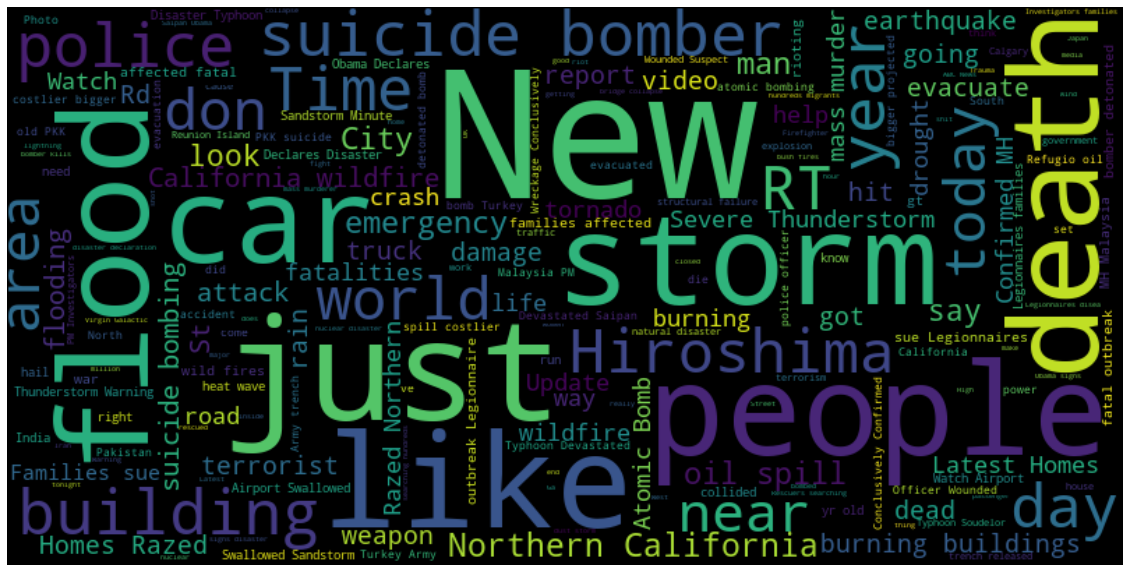

In [6]:
#frequently occuring word of disaster related tweets
text = " ".join(tweet for tweet in df[df['target']==1]['text'])
stopwords = set(stop_words)
wordcloud = WordCloud(stopwords=stopwords, background_color="black",regexp=r"[a-zA-Z]{2,}",width=800, height=400).generate(text)
plt.figure(figsize = (20,20))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
#splitting of data to train and validation sets.
X = df.drop('target',axis=1)
y = df['target']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=2018,test_size=0.1)

In [8]:
print(X_train.shape)
print(y_train.shape)

(6752, 4)
(6752,)


In [9]:
X_test.shape

(751, 4)

# LOGISTIC REGRESSION (CVEC)

In [10]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cvec_lr = Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('lr',LogisticRegression(random_state=7))])
grid_lrc = GridSearchCV(cvec_lr,param_grid = {
    'cvec__max_features':range(500,5000,500),
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)]
},verbose = 1,cv=3,n_jobs=-1)

In [11]:
grid_lrc.fit(X_train['text'],y_train)
print(grid_lrc.score(X_test['text'],y_test))
print(grid_lrc.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.4s


0.7922769640479361
{'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1)}


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   23.1s finished


In [12]:
best_lrc=Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}",
                            max_df=0.9,min_df=2,ngram_range = (1,1),max_features=2000)),
                         ('lr',LogisticRegression(random_state=7))])
best_lrc.fit(X_train['text'],y_train)
print(best_lrc.score(X_test['text'],y_test))
lrc_coefs = pd.DataFrame(best_lrc.steps[1][1].coef_,columns = best_lrc.steps[0][1].get_feature_names()).T.sort_values(by = 0, ascending = False)
lrc_coefs

0.7922769640479361


,0
hiroshima,2.750785
earthquake,2.413685
wildfire,2.308155
casualties,2.251584
derailment,2.167487
...,...
ruin,-1.294007
lets,-1.321657
wedding,-1.454792
bags,-1.633691


# LOGISTIC REGRESSION (TF-IDF)

In [13]:
tfidf_lr = Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('lr',LogisticRegression(random_state=7))])
grid_lrt = GridSearchCV(tfidf_lr,param_grid = {
    'tvec__max_features':range(500,5000,500),
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)]
},verbose = 1,cv=3,n_jobs=-1)

In [14]:
grid_lrt.fit(X_train['text'],y_train)
print(grid_lrt.score(X_test['text'],y_test))
print(grid_lrt.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.8s


0.8042609853528628
{'tvec__max_df': 0.9, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:   20.9s finished


In [15]:
best_lrt=Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}",
                            max_df=0.9,min_df=2,ngram_range = (1,1),max_features=4000)),
                         ('lr',LogisticRegression(random_state=7))])
best_lrt.fit(X_train['text'],y_train)
print(best_lrt.score(X_test['text'],y_test))
lrt_coefs = pd.DataFrame(best_lrt.steps[1][1].coef_,columns = best_lrt.steps[0][1].get_feature_names()).T.sort_values(by = 0, ascending = False)
lrt_coefs

0.8042609853528628


,0
hiroshima,3.837308
california,2.927124
fires,2.793096
killed,2.762202
earthquake,2.756259
...,...
bags,-1.614321
ruin,-1.677384
new,-1.720530
body,-1.769357


In [16]:
def conf_unravel(true,pred):
    tn, fp, fn, tp = confusion_matrix(true, pred).ravel()
    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)

    accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
    print(f'Accuracy: {round(accuracy_clean,4)}')

    misclass_clean = (fp + fn) / (tp + tn + fp + fn)
    print(f'Misclassification Rate: {round(misclass_clean,4)}')

    spec_clean = tn / (tn + fp) #how many of the 'spam' was correctly classified
    print(f'Specificity: {round(spec_clean,4)}')

    sens_clean = tp / (tp + fn) #how many of the disasters was correctly identified
    print(f'Sensitivity: {round(sens_clean,4)}')

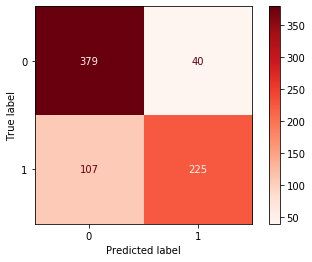

In [19]:
plot_confusion_matrix(best_lrt, X_test['text'], y_test,cmap=plt.cm.Reds,values_format='.0f');
#plt.grid(None)

In [18]:
#getting the score for the best performing Linear Regression model
conf_unravel(y_test,best_lrt.predict(X_test['text']))

True Negatives: 379
False Positives: 40
False Negatives: 107
True Positives: 225
Accuracy: 0.8043
Misclassification Rate: 0.1957
Specificity: 0.9045
Sensitivity: 0.6777


# MULTINOMIAL NB (CVEC)

In [20]:
cvec_nb = Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('nb',MultinomialNB())])
grid_nbc = GridSearchCV(cvec_nb,param_grid = {
    'cvec__max_features':range(2000,5000,100),
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)]
},cv=3,verbose=1,n_jobs=-1)

In [21]:
grid_nbc.fit(X_train['text'],y_train)
print(grid_nbc.score(X_test['text'],y_test))
print(grid_nbc.best_params_)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.0min finished


0.8042609853528628
{'cvec__max_df': 0.9, 'cvec__max_features': 4800, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}


In [22]:
best_nbc=Pipeline(steps=[('tvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}",
                            max_df=0.9,min_df=2,ngram_range = (1,2),max_features=4800)),
                         ('nb',MultinomialNB())])
best_nbc.fit(X_train['text'],y_train)
print(best_nbc.score(X_test['text'],y_test))
nbc_coefs = pd.DataFrame(best_nbc.steps[1][1].coef_,columns = best_nbc.steps[0][1].get_feature_names()).T.sort_values(by = 0, ascending = False)
nbc_coefs

0.8042609853528628


,0
news,-5.494169
california,-5.717312
police,-5.756533
suicide,-5.797355
disaster,-5.807826
...,...
crackdown impressed,-10.361703
crackdown destruction,-10.361703
crackdown,-10.361703
laugh,-10.361703


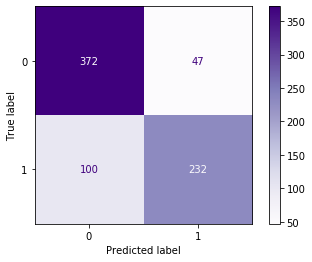

In [23]:
plot_confusion_matrix(best_nbc, X_test['text'], y_test,cmap=plt.cm.Purples,values_format='.0f')
#plt.grid(None)

In [24]:
conf_unravel(y_test,best_nbc.predict(X_test['text']))

True Negatives: 372
False Positives: 47
False Negatives: 100
True Positives: 232
Accuracy: 0.8043
Misclassification Rate: 0.1957
Specificity: 0.8878
Sensitivity: 0.6988


# MULTINOMIAL NB (TF-IDF)

In [25]:
tfidf_nb = Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('nb',MultinomialNB())])
grid_nbt = GridSearchCV(tfidf_nb,param_grid = {
    'tvec__max_features':range(2000,5000,100),
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)]
},cv=3,verbose=1,n_jobs=-1)

In [26]:
grid_nbt.fit(X_train['text'],y_train)
print(grid_nbt.score(X_test['text'],y_test))
print(grid_nbt.best_params_)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   45.4s


0.8042609853528628
{'tvec__max_df': 0.9, 'tvec__max_features': 4100, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1)}


[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  1.0min finished


In [27]:
best_nbt=Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}",
                            max_df=0.9,min_df=2,ngram_range = (1,1),max_features=4100)),
                         ('nb',MultinomialNB())])
best_nbt.fit(X_train['text'],y_train)
print(best_nbt.score(X_test['text'],y_test))
nbt_coefs = pd.DataFrame(best_nbt.steps[1][1].coef_,columns = best_nbt.steps[0][1].get_feature_names()).T.sort_values(by = 0, ascending = False)
nbt_coefs

0.8042609853528628


,0
news,-5.916515
california,-5.926813
suicide,-6.056218
hiroshima,-6.090771
disaster,-6.124975
...,...
listenlive,-9.357122
bottle,-9.357122
shitty,-9.357122
shirt,-9.357122


# RANDOM FOREST CLASSIFIER (CVEC)

In [28]:
cvec_rfc = Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('rf',RandomForestClassifier())])
grid_rfc = GridSearchCV(cvec_rfc,param_grid = {
    'cvec__max_features':range(1000,5000,100),
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range':[(1,1),(1,2),(1,3)],
    'rf__n_estimators':[10,50,100],
    'rf__max_depth':[1,3,5]
},cv=3,verbose=1,n_jobs=-1)

In [29]:
grid_rfc.fit(X_train['text'],y_train)
print(grid_rfc.score(X_test['text'],y_test))
print(grid_rfc.best_params_)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

0.6031957390146472
{'cvec__max_df': 0.95, 'cvec__max_features': 1400, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'rf__max_depth': 5, 'rf__n_estimators': 10}


In [30]:
best_rfc=Pipeline(steps=[('cvec',CountVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}",
                            max_df=0.95,min_df=3,ngram_range = (1,1),max_features=1400)),
                         ('rf',RandomForestClassifier(n_estimators=10,max_depth=5))])
best_rfc.fit(X_train['text'],y_train)
print(best_rfc.score(X_test['text'],y_test))

0.6178428761651131


# RANDOM FOREST CLASSIFIER (TF-IDF)

In [31]:
tfidf_rft = Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}")),('rf',RandomForestClassifier())])
grid_rft = GridSearchCV(tfidf_rft,param_grid = {
    'tvec__max_features':range(1000,5000,100),
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__ngram_range':[(1,1),(1,2),(1,3)],
    'rf__n_estimators':[10,50,100],
    'rf__max_depth':[1,3,5]
},cv=3,verbose=1,n_jobs=-1)

In [32]:
grid_rft.fit(X_train['text'],y_train)
print(grid_rft.score(X_test['text'],y_test))
print(grid_rft.best_params_)

Fitting 3 folds for each of 4320 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.0min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

0.6151797603195739
{'rf__max_depth': 5, 'rf__n_estimators': 10, 'tvec__max_df': 0.9, 'tvec__max_features': 1500, 'tvec__min_df': 3, 'tvec__ngram_range': (1, 1)}


In [33]:
best_rft=Pipeline(steps=[('tvec',TfidfVectorizer(analyzer='word',stop_words=stop_words,token_pattern=r"[a-zA-Z]{2,}",
                            max_df=0.9,min_df=3,ngram_range = (1,1),max_features=1500)),
                         ('rf',RandomForestClassifier(n_estimators=10,max_depth=5))])
best_rft.fit(X_train['text'],y_train)
print(best_rft.score(X_test['text'],y_test))

0.6364846870838882


# KAGGLE TEST DATA PREDICTIONS

In [79]:
X_test = pd.read_csv('./data/test.csv')
X_test.shape

(3263, 4)

In [80]:
nb_predictions = best_nbc.predict(X_test['text'])
len(nb_predictions)

3263

In [81]:
lr_predictions = best_lrt.predict(X_test['text'])
len(lr_predictions)

3263

In [82]:
print(pd.Series(lr_predictions).value_counts())
print(pd.Series(nb_predictions).value_counts())

0    2180
1    1083
dtype: int64
0    2132
1    1131
dtype: int64


In [83]:
all_subs = pd.read_csv('./data/submission.csv')
all_subs.shape

(3263, 2)

In [38]:
all_subs['lr_target'] = lr_predictions
all_subs['nb_target'] = nb_predictions

In [84]:
all_subs.to_csv('./data/all_subs.csv',index=False)

# Evaluating on CRISISLEX T6 dataset

In [85]:
#importing all datasets
sandy_df = pd.read_csv('data/2012_Sandy_Hurricane/2012_Sandy_Hurricane-ontopic_offtopic.csv')
alberta_df = pd.read_csv('data/2013_Alberta_Floods/2013_Alberta_Floods-ontopic_offtopic.csv')
boston_df = pd.read_csv('data/2013_Boston_Bombings/2013_Boston_Bombings-ontopic_offtopic.csv')
oklahoma_df = pd.read_csv('data/2013_Oklahoma_Tornado/2013_Oklahoma_Tornado-ontopic_offtopic.csv')
queensland_df = pd.read_csv('data/2013_Queensland_Floods/2013_Queensland_Floods-ontopic_offtopic.csv')
west_texas_df = pd.read_csv('data/2013_West_Texas_Explosion/2013_West_Texas_Explosion-ontopic_offtopic.csv')
super_df = pd.concat([sandy_df,alberta_df,boston_df,oklahoma_df,queensland_df,west_texas_df])
super_df.shape

import preprocessor as p

def tidy_up(dataframe): #renaming columns to remove the 'space' and to change the label to binary.
    dataframe.rename(columns={" tweet":"tweet"," label":"label"},inplace=True)
    dataframe.label = dataframe.label.map({'off-topic':0,'on-topic':1})
    dataframe.drop(columns=['tweet id'],inplace=True)
    dataframe.drop_duplicates(subset='tweet',keep='last',inplace=True)
    p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.RESERVED)
    dataframe['tweet']=[p.clean(x) for x in dataframe['tweet']]
    dataframe['tweet']=[re.sub(r'(&amp;)|(&lt;)|(b&gt;)|([!?.]*[!?.])',"",x) for x in dataframe['tweet']]
tidy_up(super_df)
super_df.sample(5)


,tweet,label
5069,Going to be on the Arlene Bynon show again tod...,1
9750,: More images from the Queensland flood crisis...,1
3412,"love the show, Your my favorite and I'll leave...",0
5633,Image Leads to Hunt for Boston Bombing Suspect...,1
801,nakin tried to reach out with the Force to #se...,0


In [87]:
#prediction using the best NB and LR models.
nb_crisislex_predictions = best_nbc.predict(super_df['tweet'])
print(len(nb_crisislex_predictions))
lr_crisislex_predictions = best_lrt.predict(super_df['tweet'])
print(len(lr_crisislex_predictions))

55377
55377


In [88]:
super_df['lr_label'] = lr_crisislex_predictions
super_df['nb_label'] = nb_crisislex_predictions

In [89]:
tn, fp, fn, tp = confusion_matrix(super_df['label'], super_df['lr_label']).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
print(f'Accuracy: {round(accuracy_clean,4)}')

misclass_clean = (fp + fn) / (tp + tn + fp + fn)
print(f'Misclassification Rate: {round(misclass_clean,4)}')

spec_clean = tn / (tn + fp) #how many of the 'spam' was correctly classified
print(f'Specificity: {round(spec_clean,4)}')

sens_clean = tp / (tp + fn) #how many of the disasters was correctly identified
print(f'Sensitivity: {round(sens_clean,4)}')

True Negatives: 25480
False Positives: 2018
False Negatives: 12208
True Positives: 15671
Accuracy: 0.7431
Misclassification Rate: 0.2569
Specificity: 0.9266
Sensitivity: 0.5621


In [90]:
tn, fp, fn, tp = confusion_matrix(super_df['label'], super_df['nb_label']).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

accuracy_clean = (tp + tn) / (tp + tn + fp + fn)
print(f'Accuracy: {round(accuracy_clean,4)}')

misclass_clean = (fp + fn) / (tp + tn + fp + fn)
print(f'Misclassification Rate: {round(misclass_clean,4)}')

spec_clean = tn / (tn + fp) #how many of the 'spam' was correctly classified
print(f'Specificity: {round(spec_clean,4)}')

sens_clean = tp / (tp + fn) #how many of the disasters was correctly identified
print(f'Sensitivity: {round(sens_clean,4)}')

True Negatives: 24745
False Positives: 2753
False Negatives: 12204
True Positives: 15675
Accuracy: 0.7299
Misclassification Rate: 0.2701
Specificity: 0.8999
Sensitivity: 0.5623
